# Variance Risk Premium (VRP) Strategy Analysis

---

## Executive Summary

This onboarding project studies the **Variance Risk Premium (VRP)** - the tendency for *implied variance* to exceed *subsequent realized variance* - using **S&P 500 returns** and **VIX as an implied-vol proxy**.  

Because I don't have full historical option chains, the analysis is framed as a **variance-swap proxy backtest**, with careful attention to **methodology, timing assumptions, and honest limitations**.

### Key Findings
- **VRP is positive on average in this sample** (implied vol > realized vol most days), consistent with the idea that variance sellers earn compensation for bearing tail risk.
- A previous version of the backtest produced an unrealistically high Sharpe due to:
  - **Lookahead in exit logic**, and
  - **Incorrect realized-variance scaling under early exits** (annualizing with H even when held < H).
  Fixing both materially reduced performance metrics.
- Under corrected accounting, **ALWAYS-ON short-variance exposure captures most of the proxy payoff**, while timing rules and exits mainly affect **risk profile / drawdowns**, not robust alpha.

**Important:** P&L in this notebook is measured in **variance points per unit notional** (proxy payoff), not portfolio returns on capital.


## 1. Setup and Data

### What is the Variance Risk Premium?

The VRP is the difference between:
- **Implied Variance:** What options traders expect (from VIX)
- **Realized Variance:** What actually happens (from SPX returns)

On average, implied variance > realized variance, creating a profit opportunity for variance sellers (option sellers, volatility arbitrageurs).

### Why Does VRP Exist?

1. **Hedging Demand:** Investors pay premium for downside protection
2. **Risk Aversion:** People fear volatility spikes more than they value calm markets
3. **Structural Flows:** Institutional hedging creates persistent bid for volatility

### Our Approach (Proxy Instrument)

We simulate the payoff of a **short-variance exposure** using proxies:
- **Implied variance proxy (from VIX):** $$IV_t^2$$
- **Realized variance proxy:** annualized sum of squared log returns over the holding window

This is a **research proxy**, not a production replication:
- VIX is ~30 calendar-day implied volatility, not a tradable variance swap strike
- Early exits are modeled as stopping exposure and settling against realized variance over the held window (not true mark-to-market closeout)


In [25]:
# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Libraries loaded successfully")

Libraries loaded successfully


In [43]:
# Download data
START = "2010-01-01"
END = "2026-01-01"
ANN = 252

sp = yf.download("^GSPC", start=START, end=END, progress=False, auto_adjust=False)
vx = yf.download("^VIX", start=START, end=END, progress=False, auto_adjust=False)

df = pd.DataFrame(index=sp.index)
df["spx"] = sp["Close"]
df["vix"] = vx["Close"]
df = df.dropna().sort_index()
df["log_ret"] = np.log(df["spx"] / df["spx"].shift(1))


---

## 2. Feature Engineering

### Realized Volatility
Calculate trailing realized volatility using a 21-day rolling window of squared log returns:

$$RV_t = \sqrt{\frac{252}{21} \sum_{i=1}^{21} r_{t-i}^2}$$

### Implied Volatility
Using VIX as a proxy for 30-day implied volatility:

$$IV_t = \frac{VIX_t}{100}$$

### Variance Risk Premium
The VRP is the difference in variance terms:

$$VRP_t = IV_t^2 - RV_t^2$$

### VRP Z-Score
Standardizing VRP using a rolling Z-score:

$$Z_t = \frac{VRP_t - \mu_{VRP}}{\sigma_{VRP}}$$

where μ and σ are calculated over a rolling window.

In [44]:
def calculate_features(data, rv_window=21, norm_window=126):
    d = data.copy()
    d["rv"] = np.sqrt(
        (ANN / rv_window) * d["log_ret"].shift(1).pow(2).rolling(rv_window).sum())
    # Implied volatility from VIX
    d["iv"] = d["vix"] / 100.0
    # Variance Risk Premium (variance units)
    d["vrp"] = d["iv"]**2 - d["rv"]**2
    # VRP Z-score (standardized over rolling window)
    mu = d["vrp"].rolling(norm_window).mean()
    sd = d["vrp"].rolling(norm_window).std()
    d["vrp_z"] = (d["vrp"] - mu) / sd
    return d

# Calculate features with optimized parameters (126-day normalization window)
df = calculate_features(df, rv_window=21, norm_window=126)

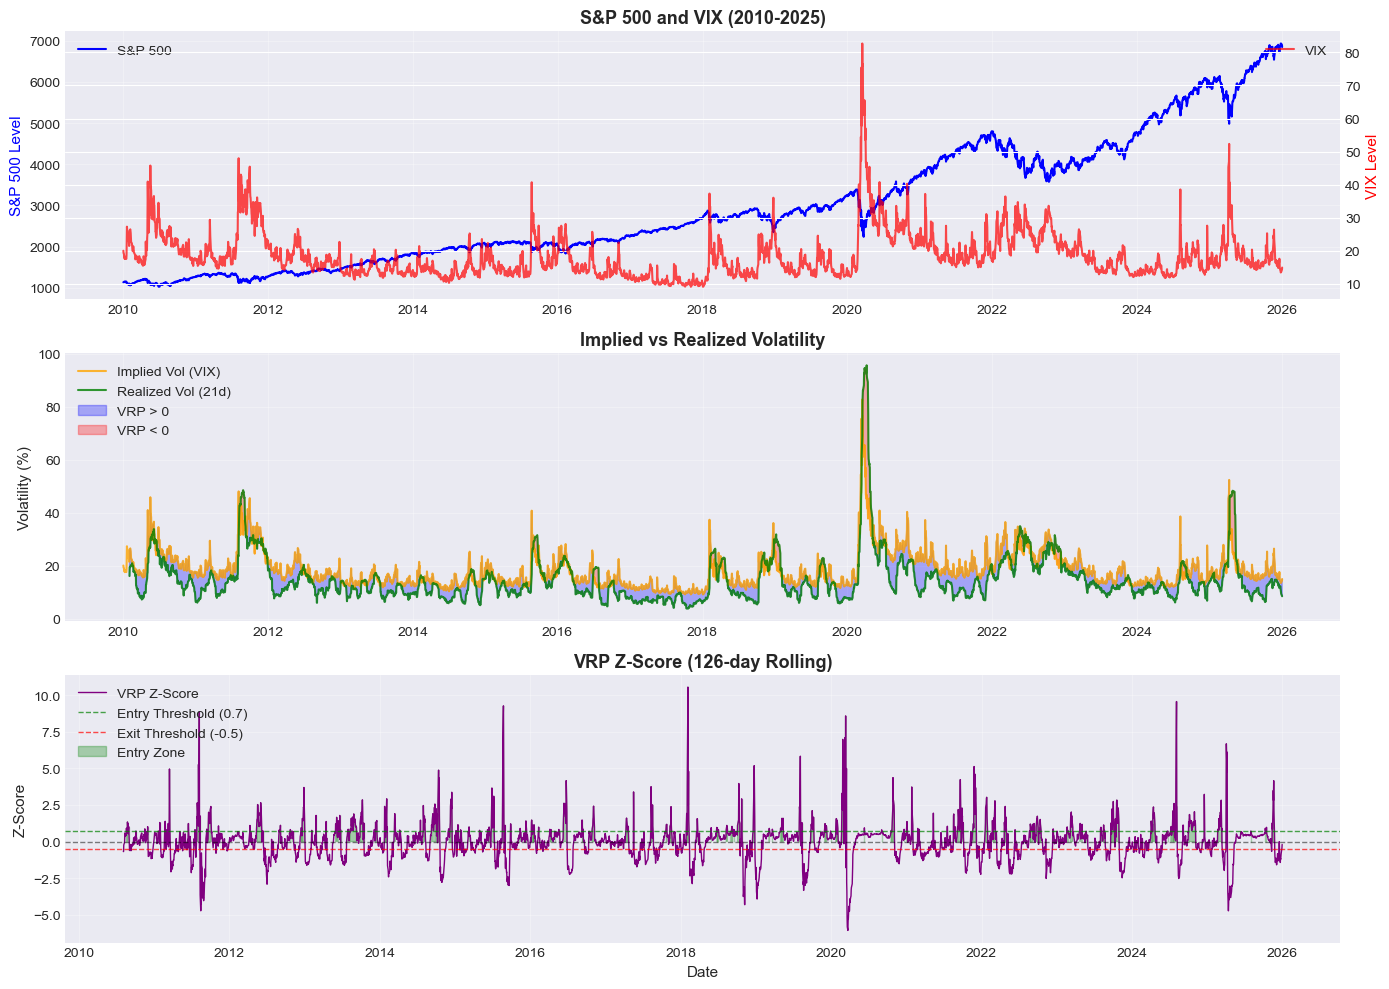


VRP Statistics (full sample):
Mean VRP: 0.008293
Median VRP: 0.010084
% of days VRP > 0: 84.9%
Mean IV: 18.41%
Mean RV: 14.77%


In [45]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# SPX and VIX
ax1 = axes[0]
ax1_twin = ax1.twinx()
ax1.plot(df.index, df['spx'], 'b-', linewidth=1.5, label='S&P 500')
ax1_twin.plot(df.index, df['vix'], 'r-', linewidth=1.5, alpha=0.7, label='VIX')
ax1.set_ylabel('S&P 500 Level', color='b', fontsize=11)
ax1_twin.set_ylabel('VIX Level', color='r', fontsize=11)
ax1.set_title('S&P 500 and VIX (2010-2025)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')

# IV vs RV
ax2 = axes[1]
ax2.plot(df.index, df['iv']*100, 'orange', linewidth=1.5, label='Implied Vol (VIX)', alpha=0.8)
ax2.plot(df.index, df['rv']*100, 'green', linewidth=1.5, label='Realized Vol (21d)', alpha=0.8)
ax2.fill_between(df.index, df['iv']*100, df['rv']*100, 
                 where=(df['iv'] > df['rv']), alpha=0.3, color='blue', label='VRP > 0')
ax2.fill_between(df.index, df['iv']*100, df['rv']*100, 
                 where=(df['iv'] <= df['rv']), alpha=0.3, color='red', label='VRP < 0')
ax2.set_ylabel('Volatility (%)', fontsize=11)
ax2.set_title('Implied vs Realized Volatility', fontsize=13, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# VRP Z-score
ax3 = axes[2]
ax3.plot(df.index, df['vrp_z'], 'purple', linewidth=1, label='VRP Z-Score')
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax3.axhline(y=0.7, color='green', linestyle='--', linewidth=1, alpha=0.7, label='Entry Threshold (0.7)')
ax3.axhline(y=-0.5, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Exit Threshold (-0.5)')
ax3.fill_between(df.index, 0, df['vrp_z'], where=(df['vrp_z'] > 0.7), 
                 alpha=0.3, color='green', label='Entry Zone')
ax3.set_ylabel('Z-Score', fontsize=11)
ax3.set_title('VRP Z-Score (126-day Rolling)', fontsize=13, fontweight='bold')
ax3.set_xlabel('Date', fontsize=11)
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nVRP Statistics (full sample):")
print(f"Mean VRP: {df['vrp'].mean():.6f}")
print(f"Median VRP: {df['vrp'].median():.6f}")
print(f"% of days VRP > 0: {100 * (df['vrp'] > 0).mean():.1f}%")
print(f"Mean IV: {df['iv'].mean()*100:.2f}%")
print(f"Mean RV: {df['rv'].mean()*100:.2f}%")

---

## 3. Strategy Implementation

### Strategy Variants


1) **BASELINE (low exposure)**
- Entry: VRP Z-score ≥ 95th percentile (train), VIX < 20  
- Non-overlapping trades, holding horizon \(H = 21\) trading days

2) **IMPROVED (higher exposure + dynamic exits)**
- Entry: VRP Z-score ≥ 70th percentile (train), VIX < 25  
- Position sizing based on VRP Z-score (0.5x vs 1.0x notional)
- **Dynamic exits** triggered by crisis proxies (VIX, VRP-z, large negative return)

3) **ALWAYS-ON (benchmark VRP beta)**
- No timing; continuous short-variance proxy exposure  
- Serves as the “VRP beta” baseline to test whether timing adds value

### Important Implementation Note:
Dynamic exits are implemented **without lookahead**:
- Exit decisions for day \(t\) only use information available at end of day \(t-1\).
- If a position exits early, realized variance is annualized using the **actual holding window**, not the planned horizon \(H\).


In [47]:
def non_overlapping_entries(signal, H=21):
    signal = signal.fillna(False).astype(bool)
    entries = pd.Series(False, index=signal.index)
    i = 0
    s = signal.values
    while i < len(s):
        if s[i]:
            entries.iloc[i] = True
            i += H 
        else:
            i += 1
    return entries


def backtest_vrp_proxy(
    data,
    entries,
    H=21,
    cost_per_entry=0.0005,
    position_sizes=None,
    use_dynamic_exit=False,
    exit_vix=35.0,
    exit_vrpz=-0.5,
    exit_daily_ret=-0.03,
    daily_pnl_style="lump_at_exit",):
    required = ["iv", "log_ret", "vix", "vrp_z"]
    missing = [c for c in required if c not in data.columns]
    if missing:
        raise ValueError(f"data is missing columns: {missing}")

    entries = entries.fillna(False).astype(bool)
    idx = data.index
    n = len(data)

    iv2 = (data["iv"].astype(float).values) ** 2
    r2 = (data["log_ret"].fillna(0.0).astype(float).values) ** 2

    # lagged info for exits (what you know at end of t-1)
    vix_lag  = data["vix"].shift(1).values
    vrpz_lag = data["vrp_z"].shift(1).values
    ret_lag  = data["log_ret"].shift(1).values

    daily_pnl = np.zeros(n, dtype=float)
    pos = np.zeros(n, dtype=float)
    trades = []

    entry_locs = np.where(entries.values)[0]

    for e in entry_locs:
        size = 1.0 if position_sizes is None else float(position_sizes.iloc[e])
        start = e + 1
        if start >= n:
            continue
        planned_end = min(e + H, n - 1)
        end = planned_end
        if use_dynamic_exit:
            for t in range(start, planned_end + 1):
                if (vix_lag[t] > exit_vix) or (vrpz_lag[t] < exit_vrpz) or (ret_lag[t] < exit_daily_ret):
                    end = t - 1
                    break

        if end < start:
            daily_pnl[e] -= cost_per_entry
            trades.append({
                "entry_date": idx[e], "exit_date": idx[e], "n_days": 0,
                "size": size, "K_iv2": iv2[e], "RV": np.nan,
                "pnl": -cost_per_entry, "reason": "exit_before_entry_day"
            })
            continue

        window = np.arange(start, end + 1)
        n_days = len(window)
        RV = (ANN / n_days) * r2[window].sum()
        K = iv2[e]
        trade_pnl = size * (K - RV) - cost_per_entry

        pos[window] = size
        if daily_pnl_style == "lump_at_exit":
            daily_pnl[end] += trade_pnl
        elif daily_pnl_style == "drip":
            daily_pnl[window] += (trade_pnl / n_days)
        else:
            raise ValueError("daily_pnl_style must be 'lump_at_exit' or 'drip'")

        trades.append({
            "entry_date": idx[e], "exit_date": idx[end], "n_days": n_days,
            "size": size, "K_iv2": K, "RV": RV, "pnl": trade_pnl,
            "reason": "held_until_exit_rule_or_maturity"})

    trades_df = pd.DataFrame(trades)
    pnl_s = pd.Series(daily_pnl, index=idx, name="pnl")
    pos_s = pd.Series(pos, index=idx, name="position")

    return trades_df, pnl_s, pos_s



---

## 4. Backtest Execution

### Train/Test Split
- **Train:** 2010-2020 (parameter calibration)
- **Test:** 2021-2025 (validation)

Splitting DF to prevent model overfitting 

In [48]:

TRAIN_END = "2020-12-31"
train = df.loc[:TRAIN_END].copy()
test = df.loc[pd.to_datetime(TRAIN_END) + pd.Timedelta(days=1):].copy()

In [49]:
# STRATEGY 1: BASELINE
df_baseline = calculate_features(df, rv_window=21, norm_window=252)
train_baseline = df_baseline.loc[:TRAIN_END]
zthr_baseline = train_baseline["vrp_z"].quantile(0.95)
print(f"  Entry threshold (95th percentile): {zthr_baseline:.3f}")
signal_baseline = (df_baseline["vrp_z"] >= zthr_baseline) & (df_baseline["vix"] < 20)
entries_baseline = non_overlapping_entries(signal_baseline, H=21)

trades_baseline, pnl_baseline, pos_baseline = backtest_vrp_proxy(
    data=df_baseline,
    entries=entries_baseline,
    H=21,
    cost_per_entry=0.0005,
    position_sizes=None,
    use_dynamic_exit=False,
    daily_pnl_style="lump_at_exit"
)


print(f"  Total entries: {entries_baseline.sum()}")
print(f"  Average exposure: {100 * pos_baseline.mean():.1f}%")

# STRATEGY 2: IMPROVED
train_improved = df.loc[:TRAIN_END]
zthr_improved = train_improved["vrp_z"].quantile(0.70)
print(f"  Entry threshold (70th percentile): {zthr_improved:.3f}")
signal_improved = (df["vrp_z"] >= zthr_improved) & (df["vix"] < 25)
entries_improved = non_overlapping_entries(signal_improved, H=21)
position_sizes = pd.Series(1.0, index=df.index) 
position_sizes[df['vrp_z'] < 1.0] = 0.5 
position_sizes[df['vrp_z'] >= 1.0] = 1.0  

trades_improved, pnl_improved, pos_improved = backtest_vrp_proxy(
    data=df,
    entries=entries_improved,
    H=21,
    cost_per_entry=0.0005,
    position_sizes=position_sizes,
    use_dynamic_exit=True,
    exit_vix=35,
    exit_vrpz=-0.5,
    exit_daily_ret=-0.03,
    daily_pnl_style="lump_at_exit"
)

print("  Early-exit rate:", (trades_improved["n_days"] < 21).mean())
print("  Avg n_days:", trades_improved["n_days"].mean())
print(f"  Total entries: {entries_improved.sum()}")
print(f"  Average exposure: {100 * pos_improved.mean():.1f}%")
print(f"  Average position size: {position_sizes[entries_improved].mean():.2f}x")

# STRATEGY 3: ALWAYS-ON (Benchmark)
print("\nRunning ALWAYS-ON strategy...")
signal_always = pd.Series(True, index=df.index)
entries_always = non_overlapping_entries(signal_always, H=21)
trades_always, pnl_always, pos_always = backtest_vrp_proxy(
    data=df,
    entries=entries_always,
    H=21,
    cost_per_entry=0.0005,       
    position_sizes=None,
    use_dynamic_exit=False,
    daily_pnl_style="lump_at_exit"
)


print(f"  Total entries: {entries_always.sum()}")
print(f"  Average exposure: {100 * pos_always.mean():.1f}%")

  Entry threshold (95th percentile): 1.367
  Total entries: 21
  Average exposure: 11.0%
  Entry threshold (70th percentile): 0.412
  Early-exit rate: 0.5267857142857143
  Avg n_days: 14.946428571428571
  Total entries: 112
  Average exposure: 23.8%
  Average position size: 0.58x

Running ALWAYS-ON strategy...
  Total entries: 192
  Average exposure: 100.0%


---
---

## 5. Performance Analysis

### What the Metrics Mean in This Notebook

Because the backtest is defined as a **trade-level variance-swap proxy payoff**, the primary metrics are **trade-based**, not daily-return based.

**Primary (Trade-Level) Metrics**
1) **Mean P&L per trade** and **Std P&L per trade**
2) **Trade t-stat:** $$( \bar{x} / (s/\sqrt{n}) )$$ — strength of evidence that mean payoff > 0
3) **Sharpe (trade-scaled):** scaled by trades/year using average holding days
4) **Worst trades / tail behavior:** critical for short-vol strategies

**Secondary (Daily) Metrics:**

- Daily Sharpe / drawdown can be shown as diagnostics, but must be interpreted carefully:
-   When P&L is recorded at exit (lump-sum), the daily series is sparse and not true MTM.
-   A “dripped” daily series can be used for attribution but is not a literal tradable MTM without option marks.


In [50]:
def performance_stats(pnl, pos, name="Strategy"):
    pnl = pnl.dropna()
    eq = pnl.cumsum()
    mu = pnl.mean()
    sd = pnl.std(ddof=1)
    sharpe = (mu / sd * np.sqrt(252)) if sd > 0 else np.nan
    
    pnl_active = pnl[pos > 0]
    if len(pnl_active) > 0:
        mu_active = pnl_active.mean()
        sd_active = pnl_active.std(ddof=1)
        sharpe_active = (mu_active / sd_active * np.sqrt(252)) if sd_active > 0 else np.nan
    else:
        sharpe_active = np.nan
    
    total_return = eq.iloc[-1] if len(eq) > 0 else 0
    years = len(pnl) / 252
    annual_return = (total_return / years) if years > 0 else 0
    
    running_max = eq.cummax()
    drawdown = eq - running_max
    max_dd = drawdown.min()
    exposure = 100 * (pos > 0).mean()
    
    stats = {
        'Strategy': name,
        'Sharpe': sharpe,
        'Active Sharpe': sharpe_active,
        'Annual Return': annual_return,
        'Max Drawdown': max_dd,
        'Exposure %': exposure,
        'Total P&L': total_return
    }
    
    return stats, eq, drawdown

def trade_performance_stats(trades, name="Strategy"):
    x = trades["pnl"].dropna()
    n = len(x)
    if n < 5:
        return pd.Series({"Trades": n}, name=name)

    mean = x.mean()
    std = x.std(ddof=1)
    tstat = mean / (std / np.sqrt(n))
    win = (x > 0).mean()

    avg_days = trades["n_days"].replace(0, np.nan).mean()
    trades_per_year = ANN / avg_days
    sharpe_trade = (mean / std) * np.sqrt(trades_per_year)

    return pd.Series({
        "Trades": n,
        "WinRate (trade)": win,
        "Mean PnL (trade)": mean,
        "Std PnL (trade)": std,
        "t-stat (trade)": tstat,
        "Sharpe (trade)": sharpe_trade,
        "Avg hold days": avg_days,
    }, name=name)
def trade_performance_stats(trades, name="Strategy"):
    x = trades["pnl"].dropna()
    n = len(x)
    if n < 5:
        return pd.Series({"Trades": n}, name=name)

    mean = x.mean()
    std = x.std(ddof=1)
    tstat = mean / (std / np.sqrt(n))
    win = (x > 0).mean()

    avg_days = trades["n_days"].replace(0, np.nan).mean()
    trades_per_year = ANN / avg_days
    sharpe_trade = (mean / std) * np.sqrt(trades_per_year)

    return pd.Series({
        "Trades": n,
        "WinRate (trade)": win,
        "Mean PnL (trade)": mean,
        "Std PnL (trade)": std,
        "t-stat (trade)": tstat,
        "Sharpe (trade)": sharpe_trade,
        "Avg hold days": avg_days,
    }, name=name)

# Stats for strategies
stats_baseline, eq_baseline, dd_baseline = performance_stats(
    pnl_baseline, pos_baseline, "BASELINE"
)
stats_improved, eq_improved, dd_improved = performance_stats(
    pnl_improved, pos_improved, "IMPROVED"
)
stats_always, eq_always, dd_always = performance_stats(
    pnl_always, pos_always, "ALWAYS-ON"
)

# Summary table
summary = pd.DataFrame([stats_baseline, stats_improved, stats_always])
summary = summary.set_index('Strategy')

print("\n" + "="*80)
print("PERFORMANCE SUMMARY (Full Sample: 2010-2025)")
print("="*80)
print(summary.to_string())
print("="*80)


PERFORMANCE SUMMARY (Full Sample: 2010-2025)
             Sharpe  Active Sharpe  Annual Return  Max Drawdown  Exposure %  Total P&L
Strategy                                                                              
BASELINE   0.179088       0.540706       0.004474     -0.057931   10.959245   0.071440
IMPROVED   0.277583       0.430389       0.017718     -0.287319   41.600398   0.282922
ALWAYS-ON  0.449413       0.449469       0.086281     -0.806386   99.975149   1.377761


In [40]:
#Split train and test
print("\n" + "="*80)
print("TRAIN PERIOD (2010-2020)")
print("="*80)

stats_base_train, _, _ = performance_stats(
    pnl_baseline.loc[:TRAIN_END], pos_baseline.loc[:TRAIN_END], "BASELINE"
)
stats_imp_train, _, _ = performance_stats(
    pnl_improved.loc[:TRAIN_END], pos_improved.loc[:TRAIN_END], "IMPROVED"
)
stats_alw_train, _, _ = performance_stats(
    pnl_always.loc[:TRAIN_END], pos_always.loc[:TRAIN_END], "ALWAYS-ON"
)

summary_train = pd.DataFrame([stats_base_train, stats_imp_train, stats_alw_train])
summary_train = summary_train.set_index('Strategy')
print(summary_train.to_string())

print("\n" + "="*80)
print("TEST PERIOD (2021-2025) - OUT OF SAMPLE")
print("="*80)

test_start = pd.to_datetime(TRAIN_END) + pd.Timedelta(days=1)
stats_base_test, _, _ = performance_stats(
    pnl_baseline.loc[test_start:], pos_baseline.loc[test_start:], "BASELINE"
)
stats_imp_test, _, _ = performance_stats(
    pnl_improved.loc[test_start:], pos_improved.loc[test_start:], "IMPROVED"
)
stats_alw_test, _, _ = performance_stats(
    pnl_always.loc[test_start:], pos_always.loc[test_start:], "ALWAYS-ON"
)

summary_test = pd.DataFrame([stats_base_test, stats_imp_test, stats_alw_test])
summary_test = summary_test.set_index('Strategy')
print(summary_test.to_string())
print("="*80)

trade_table = pd.concat([
    trade_performance_stats(trades_baseline, "BASELINE"),
    trade_performance_stats(trades_improved, "IMPROVED"),
    trade_performance_stats(trades_always, "ALWAYS-ON"),
], axis=1).T

print(trade_table)



TRAIN PERIOD (2010-2020)
             Sharpe  Active Sharpe  Annual Return  Max Drawdown  Exposure %  Total P&L
Strategy                                                                              
BASELINE   0.178920       0.483895       0.005096     -0.057931   13.651138   0.056000
IMPROVED  -0.056551      -0.087578      -0.003858     -0.287319   41.675695  -0.042395
ALWAYS-ON  0.336534       0.336595       0.073831     -0.805386   99.963886   0.811265

TEST PERIOD (2021-2025) - OUT OF SAMPLE
             Sharpe  Active Sharpe  Annual Return  Max Drawdown  Exposure %  Total P&L
Strategy                                                                              
BASELINE   0.213367       0.946718       0.003100     -0.020009    5.019920   0.015439
IMPROVED   1.238351       1.931063       0.065323     -0.043776   41.434263   0.325317
ALWAYS-ON  1.200899       1.200899       0.133027     -0.179394  100.000000   0.662496
           Trades  WinRate (trade)  Mean PnL (trade)  Std PnL (

### Interpretation

**Key Observations:**

1) **Most proxy payoff comes from VRP beta (ALWAYS-ON exposure).**  
ALWAYS-ON generally produces the highest mean payoff per trade in this proxy framework. This suggests the main driver is persistent exposure to VRP (Beta), not precise timing (alpha).

2) **Timing rules did not produce robust alpha in the full sample.**  
The IMPROVED strategy increases trade count and adjusts risk through exits, but does not consistently beat ALWAYS-ON on average trade payoff.

3) **Dynamic exits primarily change tail exposure, not expected return.**  
Exits can reduce catastrophic drawdowns in crisis periods, but they may also cut off premium collection - the result is usually a risk/return tradeoff rather than free alpha.

4) **Out-of-sample performance must be interpreted as regime-dependent.**  
If a subperiod shows very high Sharpe, check whether the ALWAYS-ON benchmark also improves (favorable regime for short variance) rather than attributing it to timing skill.


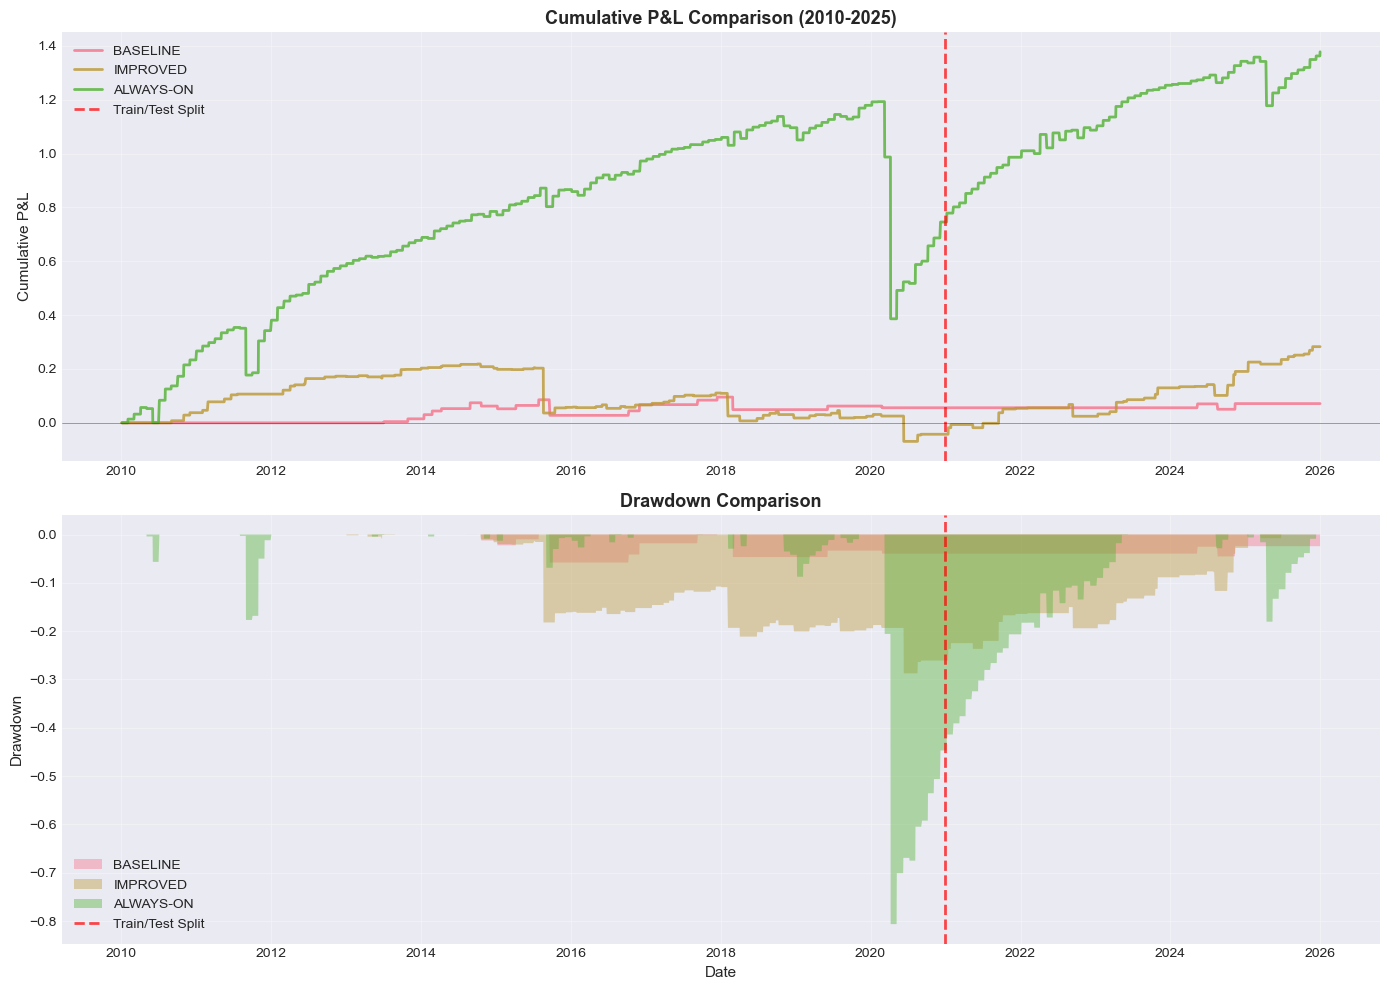


COVID-19 Crash Period (2020-02-01 to 2020-05-01):
  BASELINE drawdown: -0.0396
  IMPROVED drawdown: -0.1933
  ALWAYS-ON drawdown: -0.8064
  Dynamic exits helped IMPROVED limit losses


In [51]:
# Visualizating cum. PnL
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Full period
ax1 = axes[0]
ax1.plot(eq_baseline.index, eq_baseline, linewidth=2, label='BASELINE', alpha=0.8)
ax1.plot(eq_improved.index, eq_improved, linewidth=2, label='IMPROVED', alpha=0.8)
ax1.plot(eq_always.index, eq_always, linewidth=2, label='ALWAYS-ON', alpha=0.8)
ax1.axvline(pd.to_datetime(TRAIN_END), color='red', linestyle='--', 
            linewidth=2, alpha=0.7, label='Train/Test Split')
ax1.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
ax1.set_ylabel('Cumulative P&L', fontsize=11)
ax1.set_title('Cumulative P&L Comparison (2010-2025)', fontsize=13, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

# Drawdown
ax2 = axes[1]
ax2.fill_between(dd_baseline.index, 0, dd_baseline, alpha=0.4, label='BASELINE')
ax2.fill_between(dd_improved.index, 0, dd_improved, alpha=0.4, label='IMPROVED')
ax2.fill_between(dd_always.index, 0, dd_always, alpha=0.4, label='ALWAYS-ON')
ax2.axvline(pd.to_datetime(TRAIN_END), color='red', linestyle='--', 
            linewidth=2, alpha=0.7, label='Train/Test Split')
ax2.set_ylabel('Drawdown', fontsize=11)
ax2.set_xlabel('Date', fontsize=11)
ax2.set_title('Drawdown Comparison', fontsize=13, fontweight='bold')
ax2.legend(loc='lower left', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Highlight March 2020 (COVID crash)
covid_start = '2020-02-01'
covid_end = '2020-05-01'
print(f"\nCOVID-19 Crash Period ({covid_start} to {covid_end}):")
print(f"  BASELINE drawdown: {dd_baseline.loc[covid_start:covid_end].min():.4f}")
print(f"  IMPROVED drawdown: {dd_improved.loc[covid_start:covid_end].min():.4f}")
print(f"  ALWAYS-ON drawdown: {dd_always.loc[covid_start:covid_end].min():.4f}")
print("  Dynamic exits helped IMPROVED limit losses")

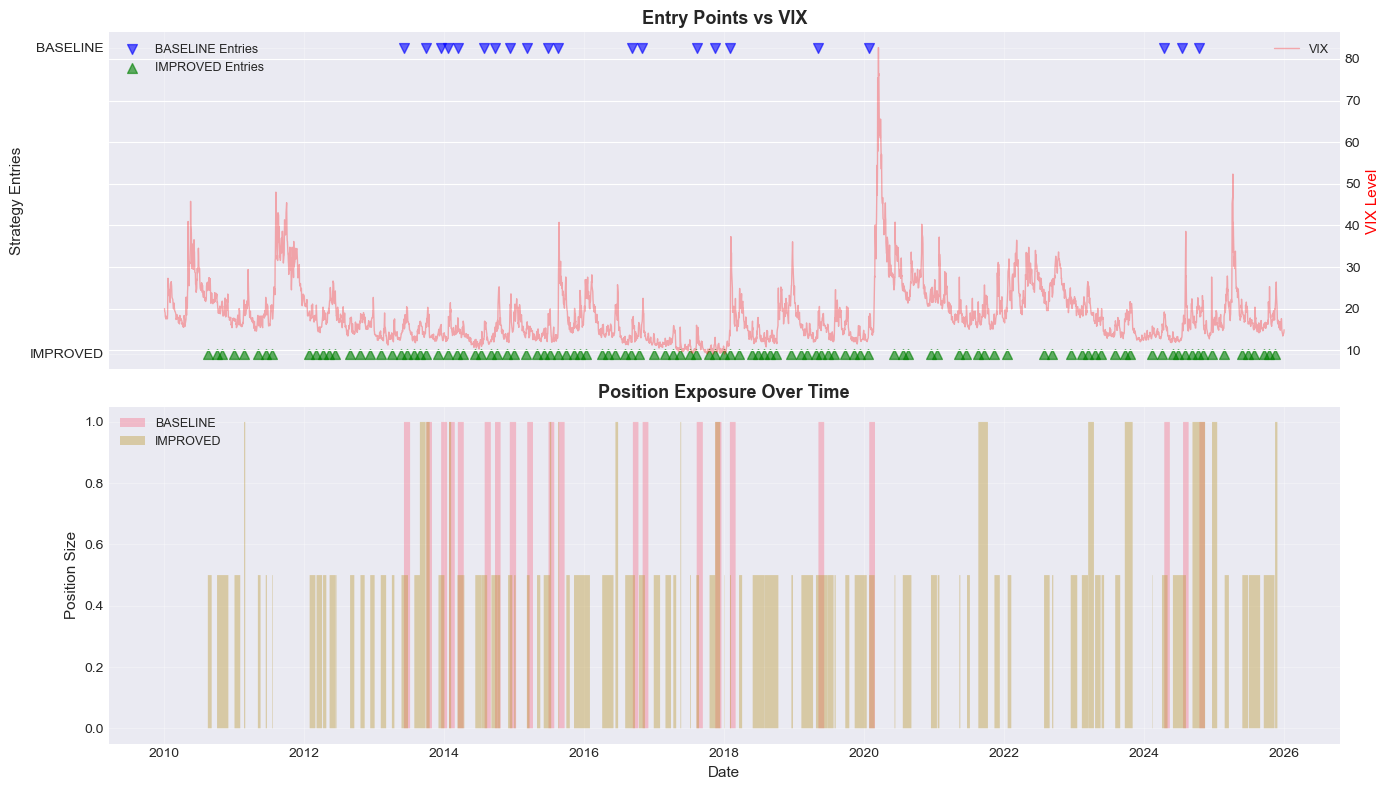

In [52]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
# Entry points
ax1 = axes[0]
ax1_twin = ax1.twinx()
ax1.scatter(df.index[entries_baseline], [1]*entries_baseline.sum(), 
            marker='v', s=50, c='blue', alpha=0.6, label='BASELINE Entries')
ax1.scatter(df.index[entries_improved], [0]*entries_improved.sum(), 
            marker='^', s=50, c='green', alpha=0.6, label='IMPROVED Entries')
ax1_twin.plot(df.index, df['vix'], 'r-', alpha=0.3, linewidth=1, label='VIX')
ax1.set_ylabel('Strategy Entries', fontsize=11)
ax1_twin.set_ylabel('VIX Level', color='r', fontsize=11)
ax1.set_title('Entry Points vs VIX', fontsize=13, fontweight='bold')
ax1.set_yticks([0, 1])
ax1.set_yticklabels(['IMPROVED', 'BASELINE'])
ax1.legend(loc='upper left', fontsize=9)
ax1_twin.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)

# Position sizing over time
ax2 = axes[1]
ax2.fill_between(pos_baseline.index, 0, pos_baseline, alpha=0.4, label='BASELINE', step='post')
ax2.fill_between(pos_improved.index, 0, pos_improved, alpha=0.4, label='IMPROVED', step='post')
ax2.set_ylabel('Position Size', fontsize=11)
ax2.set_xlabel('Date', fontsize=11)
ax2.set_title('Position Exposure Over Time', fontsize=13, fontweight='bold')
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

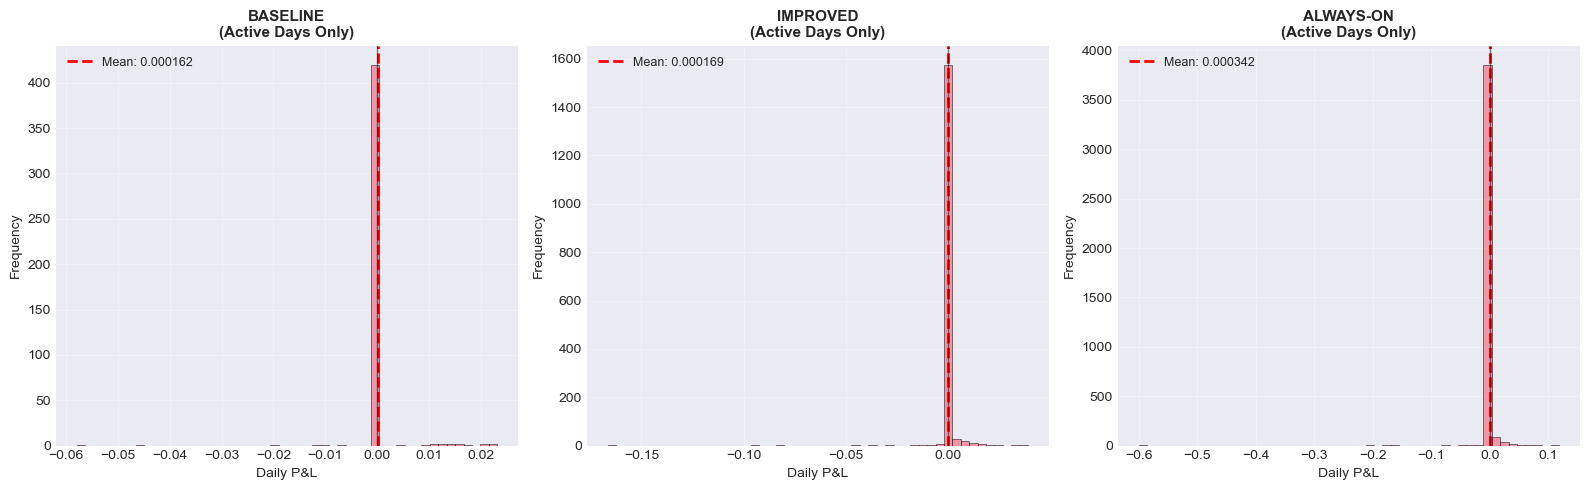


Daily P&L Statistics (Active Days):

BASELINE:
  Mean: 0.000162
  Std:  0.004756
  Win rate: 3.4%
  Best day: 0.023146
  Worst day: -0.057931

IMPROVED:
  Mean: 0.000169
  Std:  0.006234
  Win rate: 5.0%
  Best day: 0.039107
  Worst day: -0.166567

ALWAYS-ON:
  Mean: 0.000342
  Std:  0.012096
  Win rate: 4.0%
  Best day: 0.118428
  Worst day: -0.600705


In [53]:
#Daily PnL Dist.
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, pnl, pos, name in zip(axes, 
                               [pnl_baseline, pnl_improved, pnl_always],
                               [pos_baseline, pos_improved, pos_always],
                               ['BASELINE', 'IMPROVED', 'ALWAYS-ON']):
    pnl_active = pnl[pos > 0]
    
    ax.hist(pnl_active, bins=50, alpha=0.7, edgecolor='black', linewidth=0.5)
    ax.axvline(pnl_active.mean(), color='red', linestyle='--', 
               linewidth=2, label=f'Mean: {pnl_active.mean():.6f}')
    ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    ax.set_xlabel('Daily P&L', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title(f'{name}\n(Active Days Only)', fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary stats
print("\nDaily P&L Statistics (Active Days):")
for pnl, pos, name in [(pnl_baseline, pos_baseline, 'BASELINE'),
                        (pnl_improved, pos_improved, 'IMPROVED'),
                        (pnl_always, pos_always, 'ALWAYS-ON')]:
    pnl_active = pnl[pos > 0]
    print(f"\n{name}:")
    print(f"  Mean: {pnl_active.mean():.6f}")
    print(f"  Std:  {pnl_active.std():.6f}")
    print(f"  Win rate: {100 * (pnl_active > 0).mean():.1f}%")
    print(f"  Best day: {pnl_active.max():.6f}")
    print(f"  Worst day: {pnl_active.min():.6f}")

---

## 6. Limitations and Risks

#### 1) Proxy Instrument (No Option Chains)
- VIX is an index (~30 calendar-day implied vol), not the exact variance swap strike for a 21-trading-day horizon.
- Without option chains, this notebook cannot model:
  - variance swap mark-to-market at exit
  - skew / convexity / jump risk pricing

#### 2) Early Exit Modeling (Not True Closeout Pricing)
- Early exits are modeled as stopping exposure and settling against realized variance over the held window.
- In reality, closing a variance swap early requires using the **market-implied forward variance** at exit (not directly observed here).

#### 3) Capital / Margin / Execution Not Modeled
- P&L is in variance points per unit notional, not portfolio returns.
- No margin framework, funding, slippage, or dealer spreads are modeled.

#### 4) Tail Risk
- Short variance strategies can experience rare but extreme losses.
- Crisis periods (e.g., March 2020) are essential stress tests; small implementation errors can materially alter conclusions.


## 7. Conclusions and Key Takeaways

#### 1) VRP is Positive on Average (in this sample)
Implied volatility (VIX) exceeds realized volatility most of the time from 2010–2025, consistent with VRP as compensation for bearing tail risk.

#### 2) Backtests of Short-Vol Proxies Are Extremely Sensitive to Accounting
A previous implementation produced an unrealistically high Sharpe. An audit found:
- **Lookahead in exit logic**, and
- **Incorrect annualization of realized variance under early exits**
Fixing both reduced Sharpe materially. This is a core lesson: **small mechanics errors can create fake alpha** in VRP strategies.

#### 3) VRP Beta Dominates; Timing Adds Limited Robust Value
In corrected results, ALWAYS-ON short variance proxy exposure captures most of the payoff. Entry timing and exits mainly modify exposure and tail behavior rather than producing strong alpha.

#### 4) What I Would Improve With Better Data
With option chains / variance swap marks:
- Price the correct horizon strike and mark-to-market on exits
- Include skew/term-structure variables (forward variance, skew slope) for regime detection
- Convert payoff into portfolio returns with margin/capital assumptions and realistic transaction costs
